# Face Recognition #5

- We are using: DB1-Youtube 

We have used during the computation of the FAR only the encodings that have been previously generated in order to speed up the execution.
Each person is described by a vector that contains 20 encodings generated from 20 random images among all the ones available for a certain person.


In [1]:
import sys
import os
from google.colab import drive

drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/Colab Notebooks/PRIM'  # your new root path

sys.path.append(os.path.join(root_path, 'notebooks')) # for importing from utils.py

!pip install face_recognition

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive
     |████████████████████████████████| 100.2MB 42kB/s 
  Created wheel for face-recognition-models: filename=face_recognition_models-0.3.0-py2.py3-none-any.whl size=100566172 sha256=ed0fa2b1cbcb085c557e727409125402efa344bf7b0cadb2967f53f9cabed76f
  Stored in directory: /root/.cache/pip/wheels/d2/99/18/59c6c8f01e39810415c0e63f5bede7d83dfb0ffc039865465f
Successfully built face-recognition-models


In [2]:
import argparse
import pickle
import cv2
from imutils import paths
import face_recognition
import argparse
import pickle
import cv2
import os
import dlib
import matplotlib.pyplot as plt
import time
import pdb
import numpy as np

print(dlib.DLIB_USE_CUDA)

True


In the function below we compare the list of the 20 encodings of a known person with only one encoding of a different person to see the result of the algorithm. If the two person are considered the same the name is returned otherwise we have an 'unknown'.
The decision is based on the **Euclidian distance** $d$ between the encodings,two person are recognized as the same one iff:<br> 
- $d < tolerance$

In [0]:
def faceRecognitionENC(encodings_1, encodings_2, detection='cnn', show=False, tolerance = 0.6):
    '''
    New version it only works with already made encodings
    encodings_1: single encoding of the person we want to recognize
    encodings_2: encodings of the person of which we know the name
    '''
    start = time.time()


    data = encodings_2


    # initialize the list of names for each face detected
    names = []
    
    # attempt to match each encoding to our known encodings

    matches = face_recognition.compare_faces(data["encodings"],encodings_1, tolerance= tolerance)
    name = "unknown"

    # check to see if we have found a match
    if True in matches:
      # Or instead, use the known face with the smallest distance to the new face
      face_distances = face_recognition.face_distance(data["encodings"], encodings_1)
      best_match_index = np.argmin(face_distances)
      if matches[best_match_index]:
          name = data["names"][best_match_index]

    # update the list of names
    try:
        name = name.split('/')[2]
    except:
        name = name
    names.append(name)

    return names
    
def encodingsRead(path):
    ## PAY ATTENTION:: You need to create the encoding for you dataset using encode_face.py
    data = pickle.loads(open(path, "rb").read())
    return data
    

In [0]:
def faceRecOnENC(encoding_path, encodings, correct_person, detection='cnn', min_threshold = 0.85, 
                    max_threshold=0.10,
                    show=False, tolerance = 0.6):
    
    encodings_to_compare = encodingsRead(encoding_path)
    encodings_to_compare = encodings_to_compare["encodings"]#ecoding of a different person
    analysed_frames = 0
    correct_frames = 0
    negative_frames = 0
    neutrum_frames = 0
    total_frames = len(encodings_to_compare)
    start = time.time()
    
    min_frames = total_frames
    min_threshold = min_threshold
    # grab the paths to the input images in our dataset
    print("[INFO] Recognizing faces...")
    print("[INFO] elements:", total_frames)
    #pdb.set_trace()
    # loop over the image paths
    for enc in encodings_to_compare:
        # extract the person name from the image path
        #print("[INFO] processing image {}/{}".format(i + 1,len(imagePaths)))
        
        person_rec = faceRecognitionENC(enc, encodings, detection='cnn', show=show, tolerance = tolerance)
        analysed_frames += 1
        
        if(len(person_rec) >= 1):
            person = person_rec[0]
            if(person == correct_person):
                correct_frames += 1
            else:
                if(person == 'unknown'):
                    neutrum_frames += 1
                else:
                    negative_frames += 1
        else:
            neutrum_frames += 1
        
        #computing data useful for ploting statistics later
            
        if( analysed_frames > min_frames and correct_frames/analysed_frames > min_threshold):
            print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/analysed_frames)
            print('Not detected:', neutrum_frames/analysed_frames, ". Wrong recognition:", negative_frames/analysed_frames)
            correct_rate = correct_frames/analysed_frames
            neutrum_rate = neutrum_frames/analysed_frames
            negative_rate = negative_frames/analysed_frames
            end = time.time()
            print('Time:', end-start)
            return True, correct_rate, neutrum_rate, negative_rate
        
        if( analysed_frames > min_frames and correct_frames/analysed_frames < max_threshold):
            print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/analysed_frames)
            print('Not detected:', neutrum_frames/analysed_frames, ". Wrong recognition:", negative_frames/analysed_frames)
            correct_rate = correct_frames/analysed_frames
            neutrum_rate = neutrum_frames/analysed_frames
            negative_rate = negative_frames/analysed_frames
            end = time.time()
            print('Time:', end-start)
            return False, correct_rate, neutrum_rate, negative_rate
        
    #for ends
    correct_rate = correct_frames/total_frames
    neutrum_rate = neutrum_frames/total_frames
    negative_rate = negative_frames/total_frames
    end = time.time()
    print(correct_person, "Recognized after", analysed_frames, 'with accuracy:', correct_frames/total_frames)
    print('Not detected:', neutrum_frames/total_frames, ". Wrong recognition:", negative_frames/total_frames)
    print('Time:', end-start)
    if(correct_rate > min_threshold - 0.05):
        return True, correct_rate, neutrum_rate, negative_rate
    else:
        return False, correct_rate, neutrum_rate, negative_rate

In [0]:
encodings_folder = root_path + "/encodings/"
test_path = encodings_folder #same we use only encodings

The CrossedTest compare the encodings of one person with the encodings of a different one in order to compute later the Far.
Here each person is compared with all the other except that with himself.


In [0]:
def performCrossedTest(min_v=0, max_v=1000, threshold=0.85, log=False, tolerance = 0.6):
    print("-------------------------")
    print("TEST STARTED")
    print("-------------------------")
    start = time.time()
    #pdb.set_trace()
    count = 0
    enc_list = os.listdir(encodings_folder)
    test_dir = os.listdir(test_path)
    
    log_folder_base = 'test_' + str(threshold) + '_' + str(tolerance) + '/'


    for encoding in enc_list:
        count = count + 1
        if(count < min_v):
            continue
        if(count > max_v):
            break
        n_test = 0
        n_correct = 0
        enc_name = encoding[0:len(encoding)-4]#removing '.pkl' from name
        encoding_path = encodings_folder + encoding
        print('[ENC] Using encoding:', enc_name)
        start_2 = time.time()
        curr_encoding = encodingsRead(encoding_path)

        if( log == True):
          log_folder = log_folder_base + 'F/'
          try:
              os.mkdir(root_path + '/logs#5/' + log_folder_base)
              os.mkdir(root_path + '/logs#5/' + log_folder)
          except FileExistsError:
              print('Already existing folder')

          logfile = open(root_path + '/logs#5/' + log_folder + "log_" + enc_name + ".txt", "w")
        
        
        for person in test_dir:
            
            if ( enc_name == person[0:len(person)-4]):#removing '.pkl' from name 
              continue

            test_enc = test_path + person            
            person = person[0:len(person)-4]
            print('Testing on test encoding:', person)


            # test the encodings of testset               
            v, a, b, c = faceRecOnENC(test_enc, curr_encoding, person, min_threshold=threshold, show=False,tolerance = tolerance)
            if(log== True):
                line = person + " " + str(0) + " " + str(v) + " " + str(a) + " " + str(b) + " " + str(c) + "\n"
                logfile.write(line)
                #print(line)
            if( v == True):
                n_correct += 1

        if(log == True):
            logfile.close()
        end_2 = time.time()
        print("-------------------------")
        print('The comparison last:', end_2-start_2)
        print("-------------------------")
    
    end = time.time()
    print("-------------------------")
    print("TEST ENDED")
    print("-------------------------")
    print('This test last:', end-start)
    return

### Run Experiments
The aim of our experiment is to compare the encoding of each person with all the other multiple times, and every time with a different value of tolerance in order to make at each iteration a more strict comparison.

In [0]:
tol_values = [ 0.6, 0.5, 0.4, 0.3, 0.2, 0.1 ]
thr = 0.70

for tol in tol_values:
        print('********')
        print('TOLERANCE', tol)
        print('********')
        performCrossedTest(min_v=0, max_v = 200, log=True, threshold= thr, tolerance= tol)

Streaming output truncated to the last 5000 lines.
[INFO] Recognizing faces...
[INFO] elements: 20
Laura_Elena_Harring Recognized after 20 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 0.0013034343719482422
Testing on test encoding: Laura_Linney
[INFO] Recognizing faces...
[INFO] elements: 25
Laura_Linney Recognized after 25 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 0.0015099048614501953
Testing on test encoding: Larry_Flynt
[INFO] Recognizing faces...
[INFO] elements: 20
Larry_Flynt Recognized after 20 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 0.0012669563293457031
Testing on test encoding: Laura_Pausini
[INFO] Recognizing faces...
[INFO] elements: 20
Laura_Pausini Recognized after 20 with accuracy: 0.0
Not detected: 1.0 . Wrong recognition: 0.0
Time: 0.0012736320495605469
Testing on test encoding: Lauren_Hutton
[INFO] Recognizing faces...
[INFO] elements: 20
Lauren_Hutton Recognized after 20 with accuracy: 0.0


### Statistics

In [0]:
base_folder = root_path+"/logs#5/"
values = [0.65, 0.75, 0.80, 0.85, 0.90, 0.95, 0.99, 0.9999]

In [0]:
def ComputeStats(log_folder):
    files = os.listdir(log_folder)



    confirmed_rate = np.zeros(len(values))
    i = 0

    for thr in values:
        total_files = 0
        recognized = 0
        notdetected = 0
        wrong = 0
        wrong_confirmed = 0
        wrong_confirmed2 = 0
        wrong_confirmed3 = 0
        wrong_confirmed4 = 0

        ####
        one_wrong_rec = 0
        persons = 0
        for f in files:
            if( f.startswith('log') == True):
                filev = open(log_folder + f, "r")
                vector = f.split('_')
                correct_person = vector[1] + "_" + vector[2]
                lines = filev.readlines()
                persons += 1
                for line in lines: 
                    #we don't want to make statistics on the same person
                    if(line.split(' ')[0] == correct_person):
                        continue

                    total_files += 1

                    rec_flag = line.split(' ')[2]
                    rec_percentage = float(line.split(' ')[3])
                    notdec_percentage = float(line.split(' ')[4])
                    notrec_percentage = float(line.split(' ')[5])

                    recognized = recognized + rec_percentage
                    notdetected = notdetected + notdec_percentage
                    wrong = wrong + notrec_percentage

                    if(notrec_percentage > thr):
                        wrong_confirmed = wrong_confirmed + 1

        confirmed_rate[i] = wrong_confirmed / total_files
        wrong_confirmed = 0
        i = i +1

    ## equal for each iteration
    positive = recognized / total_files 
    undetected = notdetected / total_files
    negative = wrong / total_files

    wrong_rec_on_persons = one_wrong_rec / (persons-1)
    
    return positive, undetected, negative, confirmed_rate 

In [0]:
## WRONG ONES WHERE ASSIGNED TO THE PERSON EVEN HE WASN'T
def showOverallPercentage(positive, undetected, negative):
  
    labels = ['Correct', 'NotRecognized', 'Wrong']
    colors = ['Blue', 'Yellow', 'Orange']
    sizes1 = [positive, undetected, negative]
    print('Percentage of overall images that were correctly not recognized:', undetected)
    print('Percentage of overall images that were wrongly not recognized:', negative)

    plt.pie(sizes1, labels=labels, shadow=True, startangle=10, colors=colors)
    plt.title('Recognition average over all the images')
    plt.legend()
    plt.show()


We show here the percentage of images that were correctly/wrongly not recognized.
We can see from the pie histograms below that changing the $tolerance$ value (see above for the explanation of this parameter) gave us a great boost in the performances. In particular when we use a value that is lower or equal to $0.4$ all the images are correctly recognized. This means that the algorithm works really well on this particular dataset.


********
TOLERANCE _0.6
********
Percentage of overall images that were correctly not recognized: 0.9323710259112586
Percentage of overall images that were wrongly not recognized: 0.06762897408875576


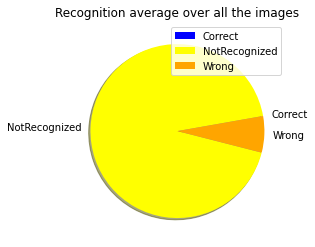

********
TOLERANCE _0.5
********
Percentage of overall images that were correctly not recognized: 0.9979078874319803
Percentage of overall images that were wrongly not recognized: 0.0020921125680209685


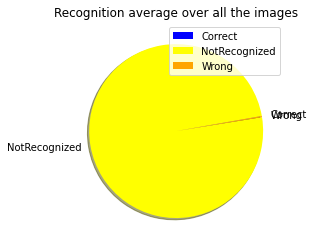

********
TOLERANCE _0.4
********
Percentage of overall images that were correctly not recognized: 0.9999261464725782
Percentage of overall images that were wrongly not recognized: 7.385352742177048e-05


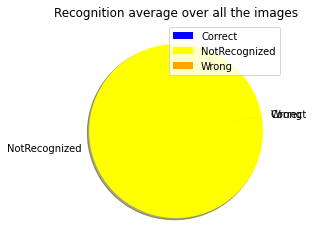

********
TOLERANCE _0.3
********
Percentage of overall images that were correctly not recognized: 1.0
Percentage of overall images that were wrongly not recognized: 0.0


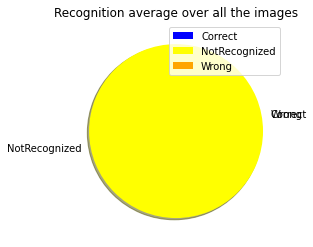

********
TOLERANCE _0.2
********
Percentage of overall images that were correctly not recognized: 1.0
Percentage of overall images that were wrongly not recognized: 0.0


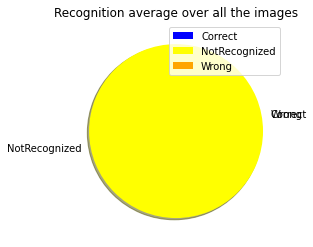

********
TOLERANCE _0.1
********
Percentage of overall images that were correctly not recognized: 1.0
Percentage of overall images that were wrongly not recognized: 0.0


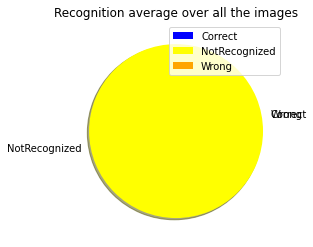

In [0]:
directories = os.listdir(base_folder)

for d in directories:
  folder = base_folder  + d + '/F/'
  print('********')
  print('TOLERANCE', d[8:])#tolerance value from folder name
  print('********')
  p, u, n, cr = ComputeStats(folder)
  showOverallPercentage(p, u, n)


So we computed the FAR. Let's compute now the TAR (True Accepted Rate) in every threshold case.

In [0]:
def computeStatsTar(folder):
  TAR_path = folder
  files = os.listdir(TAR_path)
  confirmed_rateT = np.zeros(len(values))
  i=0

  for thr in values:
      total_files = 0
      recognized = 0
      notdetected = 0
      wrong = 0
      confirmed = 0
      total_files = 0
      
      for f in files:
          if( f.startswith('log') == True):
              filev = open(TAR_path + f, "r")
              lines = filev.readlines()
              for line in lines:
                  total_files += 1

                  rec_flag = line.split(' ')[2]
                  rec_percentage = float(line.split(' ')[3])
                  notdec_percentage = float(line.split(' ')[4])
                  notrec_percentage = float(line.split(' ')[5])

                  recognized = recognized + rec_percentage
                  notdetected = notdetected + notdec_percentage
                  wrong = wrong + notrec_percentage
                  if(rec_percentage > thr):
                      confirmed = confirmed + 1

      confirmed_rateT[i] = confirmed / total_files
      
      positive = recognized / total_files 
      undetected = notdetected / total_files
      negative = wrong / total_files
      
      i = i + 1
  return positive, undetected, negative, confirmed_rateT


It's time to build a basic ROC curve when we show just the threshold that minimizes the FAR.
We can notice that when we use a $tolerance$ that is lower or equal the algorithm doesn’t make any mistake so the ROC curve is the ideal one.


********
TOLERANCE _0.6
********


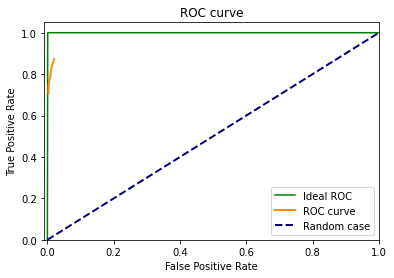

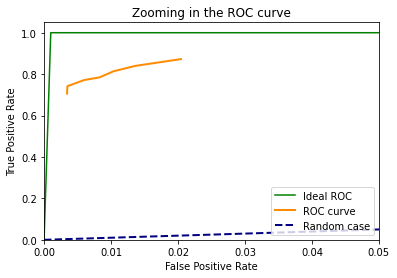

********
TOLERANCE _0.5
********


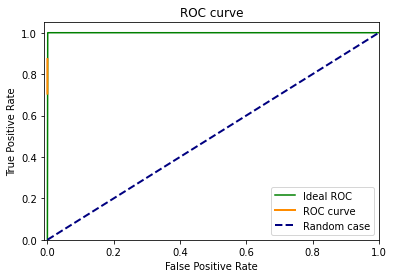

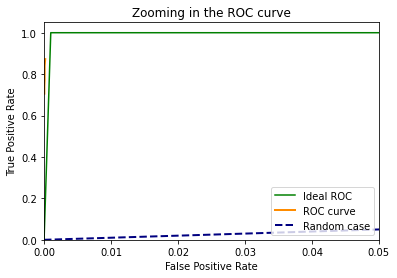

********
TOLERANCE _0.4
********


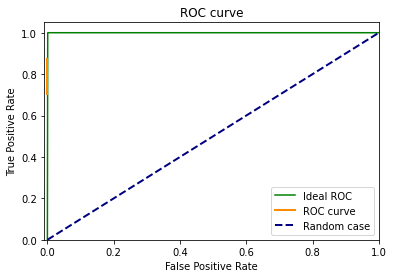

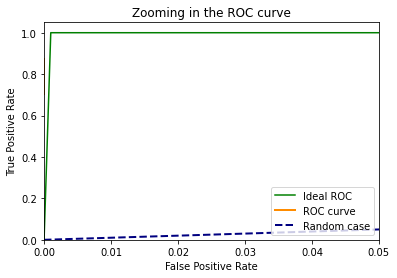

********
TOLERANCE _0.3
********


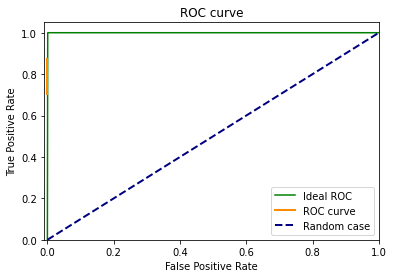

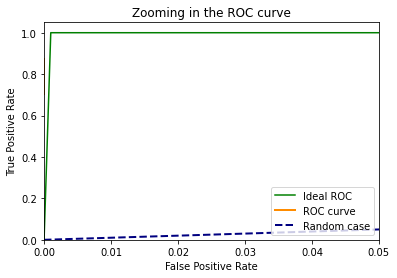

********
TOLERANCE _0.2
********


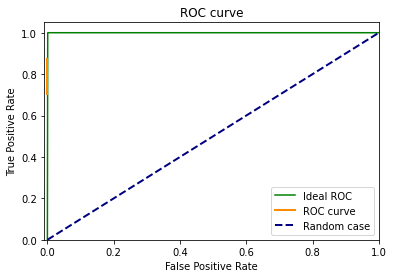

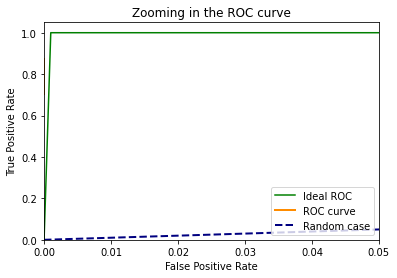

********
TOLERANCE _0.1
********


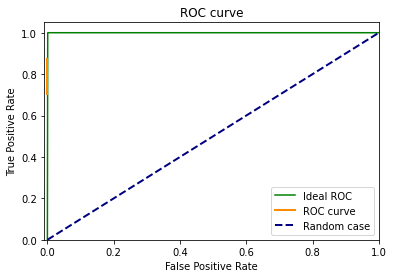

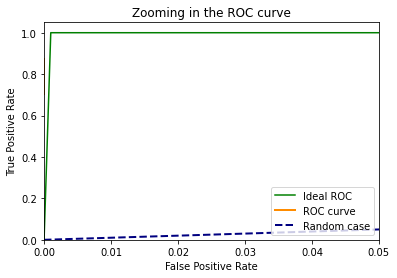

In [17]:
from sklearn.metrics import roc_curve, auc

directories = os.listdir(base_folder)

for d in directories:
    folder = base_folder  + d + '/F/'
    folder_2 = base_folder  + d + '/T/'
    print('********')
    print('TOLERANCE', d[8:])#tolerance value from folder name
    print('********')
  
    _, _, _, far = ComputeStats(folder)
    _, _, _, tar = computeStatsTar(folder_2)
    fpr = far
    tpr = tar
    exampleX = [0.0, 0.001, 0.2, 0.8, 1.0]
    exampleY = [0.0, 1.0, 1.0, 1.0, 1.0]

    plt.figure()
    lw = 2
    plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
    plt.xlim([-0.01, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

    plt.figure()
    lw = 2
    plt.plot(exampleX, exampleY, color='green', linestyle='-', label='Ideal ROC')
    plt.plot(fpr, tpr, color='darkorange',lw=lw, label='ROC curve')
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--', label='Random case')
    plt.xlim([0.0, 0.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Zooming in the ROC curve')
    plt.legend(loc="lower right")
    plt.show()

